In [ ]:
#%%

##* Imports
import os
import mne

In [ ]:
#%%

##* Data
print("Current directory: ", os.getcwd())

# All the files
#DATA_PATH = "./MNE-seizure-detector/data/chb-mit-eeg-database-1.0.0" # Dir for run command
DATA_PATH = "./data/chb-mit-eeg-database-1.0.0" # Dir for interactive
print("Dataset is ready: ", os.path.isdir(DATA_PATH))
print("##########")

# Summary of seizure recordings
#SUMMARY_FILE = os.path.join(DATA_PATH, "RECORDS-WITH-SEIZURES")
#with open(SUMMARY_FILE) as f:
#	print(f"Seizure records:\n{f.read()[:500]}.") # preview first 500 chars

# Sample inspection (.edf)
sample_raw = mne.io.read_raw_edf(os.path.join(DATA_PATH, "./chb01/chb01_01.edf"), preload=True)
#print("Sample Inspection: chb01/chb01_01.edf")
#print(sample_raw.info)
## Info:
## 8 non-empty values, bads [], chs: 23 EEG, custom_ref: false,
## highpass: 0, lowpass: 128 Hz,
## sfreq: 256 Hz
print("##########")

Current directory:  d:\Game Production\GithubProjects\MNE-Learning\MNE-seizure-detector
Dataset is ready:  True
##########
Extracting EDF parameters from d:\Game Production\GithubProjects\MNE-Learning\MNE-seizure-detector\data\chb-mit-eeg-database-1.0.0\chb01\chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-4-9579385db8c5>:17: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  sample_raw = mne.io.read_raw_edf(os.path.join(DATA_PATH, "./chb01/chb01_01.edf"), preload=True)


Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
##########


In [ ]:
#%%

##* Preprocessing

def preprocess(raw: mne.io.BaseRaw) -> mne.io.BaseRaw:
	"""
	Preprocessing the raw `mne.io.BaseRaw`.edf data > Returns processed `mne.io.BaseRaw`.edf data.
	1. Standardize the naming of channels\n
	2. Filter signals\n
	3. No resample to 256Hz needed\n
	"""
	pp_raw = raw.copy()
	pp_raw.rename_channels(lambda x: x.strip().upper()) # Std Naming to UPPERCASE
	# Filtering 0.5-40Hz (non-brain activity)
	# Signals above 40 will be contaminated by EMG/Muscle signals.
	# In a study, over 40Hz showed +0.7% detection improvement with +31% false alarms
	pp_raw.filter(0.50, 40, fir_design='firwin')
	pp_raw.notch_filter(60.) # filter exactly 60 +/- 0.5Hz

	return pp_raw

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (6.605 s)



<ipython-input-6-d1517dbc22ae>:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  sample_raw.plot_psd(fmax=120, show=False)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


<ipython-input-6-d1517dbc22ae>:4: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  preprocess(sample_raw).plot_psd(fmax=120)
d:\anaconda3\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


##########


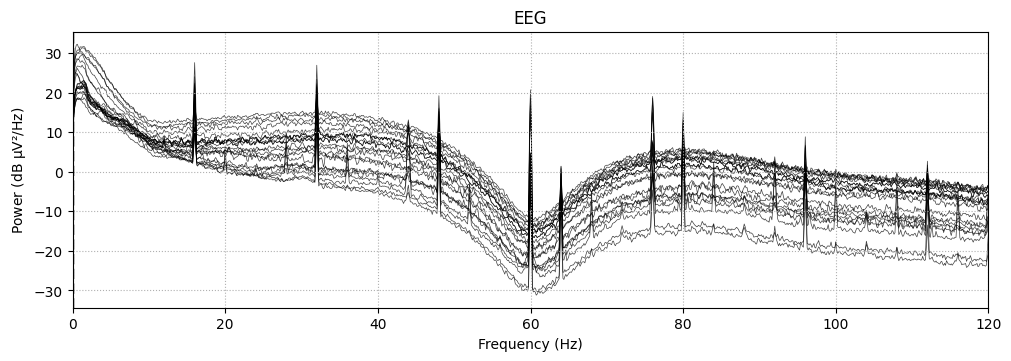

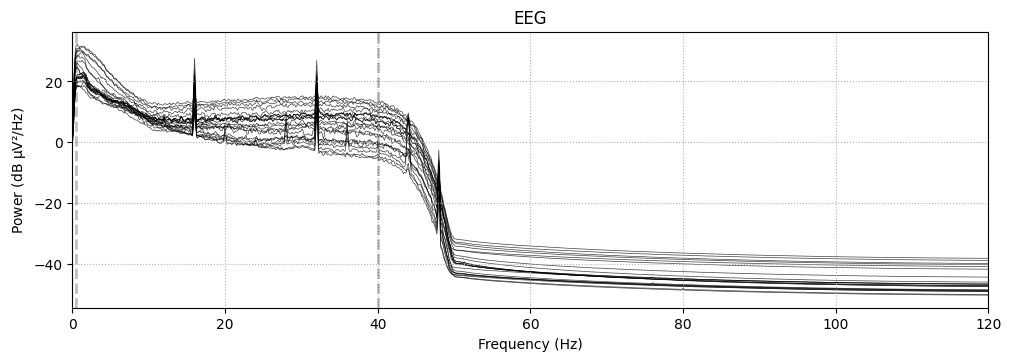

In [ ]:
#%%

# Comparison
sample_raw.plot_psd(fmax=120, show=False)
preprocess(sample_raw).plot_psd(fmax=120)
print("##########")

In [ ]:
#%%

# Seizure annotation parser (on CHB MIT DB format)
def get_seizure_labels(annotation_file: str) -> dict:
	"""
	Extract seizure start & end times.
	Looks for chb##-summary.txt file.
	Format of the .txt file:\n
	[
	File Name: chb##_##.edf,
	File Start Time: #:#:#,
	File End Time: #:#:#
	Seizure Start Time: # seconds
	Seizure End Time: # seconds
	]\n
	Returns {"edf_filename": [(start, end), ...]}
	"""
	seizure_dict: dict = {}
	current_file = None

	with open(annotation_file, 'r') as an:
		for line in an:
			line.strip()
			if line.startswith("File Name:"):
				current_file = line.split(":")[1].strip()
				seizure_dict[current_file] = []
			if line.startswith("Seizure Start Time:"):
				start = float(line.split()[3])
				next_line = next(an).strip()
				end = float(next_line.split()[3])
				seizure_dict[current_file].append((start, end))
	return seizure_dict

In [ ]:
#%%

# Annotation example
print(get_seizure_labels(os.path.join(DATA_PATH, "./chb01/chb01-summary.txt")))

{'chb01_01.edf': [], 'chb01_02.edf': [], 'chb01_03.edf': [(2996.0, 3036.0)], 'chb01_04.edf': [(1467.0, 1494.0)], 'chb01_05.edf': [], 'chb01_06.edf': [], 'chb01_07.edf': [], 'chb01_08.edf': [], 'chb01_09.edf': [], 'chb01_10.edf': [], 'chb01_11.edf': [], 'chb01_12.edf': [], 'chb01_13.edf': [], 'chb01_14.edf': [], 'chb01_15.edf': [(1732.0, 1772.0)], 'chb01_16.edf': [(1015.0, 1066.0)], 'chb01_17.edf': [], 'chb01_18.edf': [(1720.0, 1810.0)], 'chb01_19.edf': [], 'chb01_20.edf': [], 'chb01_21.edf': [(327.0, 420.0)], 'chb01_22.edf': [], 'chb01_23.edf': [], 'chb01_24.edf': [], 'chb01_25.edf': [], 'chb01_26.edf': [(1862.0, 1963.0)], 'chb01_27.edf': [], 'chb01_29.edf': [], 'chb01_30.edf': [], 'chb01_31.edf': [], 'chb01_32.edf': [], 'chb01_33.edf': [], 'chb01_34.edf': [], 'chb01_36.edf': [], 'chb01_37.edf': [], 'chb01_38.edf': [], 'chb01_39.edf': [], 'chb01_40.edf': [], 'chb01_41.edf': [], 'chb01_42.edf': [], 'chb01_43.edf': [], 'chb01_46.edf': []}
